# NLTK.VADER_LEXICON

In [1]:
import pandas as pd

df = pd.read_csv("chatgpt_reddit - Complete.csv")
df.head(5)

,Post ID,Post author,Post title,Post URL,Post flair type,Post score,Post date,Comment ID,Comment author,Comment,Comment score,Comment date,Parent Comment ID,Parent comment author
0,13ucoev,TheHybred,If ChatGPT Can't Access The Internet Then How ...,https://www.reddit.com/r/ChatGPT/comments/13uc...,Jailbreak,4318,2023-05-29 00:10:45,jlzxh5p,AutoModerator,"Hey /u/TheHybred, please respond to this comme...",1,2023-05-29 00:10:45,13ucoev,TheHybred
1,13ucoev,TheHybred,If ChatGPT Can't Access The Internet Then How ...,https://www.reddit.com/r/ChatGPT/comments/13uc...,Jailbreak,4318,2023-05-29 00:10:45,jm090r5,sdmat,The reason for this is technical and surprisin...,2482,2023-05-29 01:42:37,13ucoev,TheHybred
2,13ucoev,TheHybred,If ChatGPT Can't Access The Internet Then How ...,https://www.reddit.com/r/ChatGPT/comments/13uc...,Jailbreak,4318,2023-05-29 00:10:45,jm0k235,bojodrop,Slide the jailbreak prompt,418,2023-05-29 03:13:53,13ucoev,TheHybred
3,13ucoev,TheHybred,If ChatGPT Can't Access The Internet Then How ...,https://www.reddit.com/r/ChatGPT/comments/13uc...,Jailbreak,4318,2023-05-29 00:10:45,jm0h4ut,opi098514,Easy. He was next in line. She’s old.,631,2023-05-29 02:49:38,13ucoev,TheHybred
4,13ucoev,TheHybred,If ChatGPT Can't Access The Internet Then How ...,https://www.reddit.com/r/ChatGPT/comments/13uc...,Jailbreak,4318,2023-05-29 00:10:45,jm0dl2p,Cryptizard,It could infer that you are trying to ask it a...,193,2023-05-29 02:20:05,13ucoev,TheHybred


In [2]:
df['Comment date'].max()

'2023-06-15 18:10:08'

In [3]:
df['Comment date'].min()

'2023-04-01 19:20:17'

## Preprocessing

### Detecting deleted comments (by moderators)

In [4]:
number_of_del_comments = len(df[df['Comment'] == '[deleted]'])
print(number_of_del_comments)

930


### Detecting deleted comments (by users)

In [5]:
number_of_rem_comments = len(df[df['Comment'] == '[removed]'])
print(number_of_rem_comments)

224


In [6]:
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import re

def clean_data(review):
    
    no_punc = re.sub(r'[^\w\s]', '', review)
    no_digits = ''.join([i for i in no_punc if not i.isdigit()])
    
    return(no_digits)

df['Post title'] = df['Post title'].apply(clean_data)
df['Comment'] = df['Comment'].apply(clean_data)

In [7]:
stop_words = set(stopwords.words('english'))  # Import english stop words
df['Comment'] = df['Comment'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word.lower() not in stop_words]))  # Remove stop words

## Sentiment analysis

In [8]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()


In [9]:
df['Sentiment'] = ''
for index, row in df.iterrows():
    comment = row['Comment']
    
    scores = sia.polarity_scores(comment)
    compound_score = scores['compound']
    
    if compound_score > 0:
        sentiment = 'pos'
    elif compound_score < 0:
        sentiment = 'neg'
    else:
        sentiment = 'neu'
    
    df.at[index, 'Sentiment'] = sentiment
    
df['Sentiment'].value_counts()

pos    32942
neu    18594
neg    16529
Name: Sentiment, dtype: int64

## Sentiment distribution

In [10]:
sizes = df["Sentiment"].value_counts()
sizes[1] += number_of_del_comments
sizes[2] += number_of_rem_comments
labels = df["Sentiment"].unique()

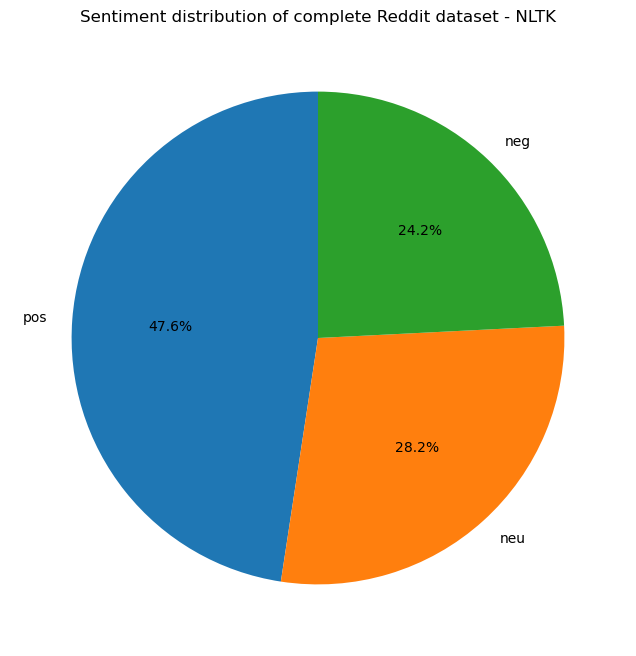

In [11]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [12, 8]

plt.pie(sizes, labels = labels, autopct = '%1.1f%%', shadow = False, startangle = 90)
plt.title("Sentiment distribution of complete Reddit dataset - NLTK")
plt.savefig("pie_nltksentiment.claudio.png")
plt.show()

# Words, bigrams and trigrams distribution for positive comments

### Detecting service messages

In [12]:
df_copy = df.copy()
df = df[df['Sentiment'] == 'pos']

In [13]:
substring = 'subredditmessage'
df_without_substr = df[~df['Comment'].str.contains(substring)]
substring = 'serverhttpsdiscord'
df_without_substr = df_without_substr[~df_without_substr['Comment'].str.contains(substring)]

## Words frequency

In [14]:
from nltk import FreqDist

tokens = []
for row in df_without_substr['Comment']:
    tokens.extend(word_tokenize(str(row).lower()))  # Tokenization and lower conversion of the strings

word_freq = FreqDist(tokens)
sorted_freq = sorted(word_freq.items(), key = lambda x: x[1], reverse = True)

In [15]:
N = 50  # number of frequent words to print
for word, freq in sorted_freq[:N]:
    print(word, freq)

like 9204
ai 8840
chatgpt 6991
people 5405
would 5244
dont 4635
use 4411
im 4263
good 4154
think 4063
get 3572
one 3541
even 3380
work 3201
time 3180
make 3131
know 3047
also 3011
gpt 2947
could 2905
thats 2893
way 2841
well 2741
better 2659
using 2590
something 2550
write 2461
really 2453
things 2396
much 2309
want 2288
youre 2247
see 2244
need 2225
going 2143
writing 2042
still 2011
say 1999
sure 1992
used 1964
right 1949
actually 1941
doesnt 1921
human 1910
cant 1774
help 1771
ask 1747
thing 1704
data 1667
lot 1637


## Bigrams distribution

In [16]:
from nltk.tokenize import word_tokenize
from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder
from nltk.metrics import BigramAssocMeasures, TrigramAssocMeasures

finder = BigramCollocationFinder.from_words(tokens)

In [17]:
bigram_freq = finder.ngram_fd
sorted_freq = sorted(bigram_freq.items(), key=lambda x: x[1], reverse=True)

In [18]:
N = 50
for ngram, freq in sorted_freq[:N]:
    print(ngram, freq)

('chat', 'gpt') 754
('dont', 'know') 544
('good', 'bot') 510
('dont', 'think') 494
('language', 'model') 456
('im', 'sure') 452
('bot', 'good') 438
('sounds', 'like') 424
('use', 'chatgpt') 385
('gon', 'na') 379
('seems', 'like') 370
('using', 'chatgpt') 345
('something', 'like') 323
('feel', 'like') 316
('use', 'ai') 308
('looks', 'like') 286
('training', 'data') 266
('make', 'sure') 266
('things', 'like') 263
('ai', 'language') 260
('using', 'ai') 252
('smart', 'robot') 252
('years', 'ago') 240
('writing', 'style') 239
('pretty', 'much') 233
('robot', 'response') 217
('response', 'automatic') 217
('ai', 'generated') 215
('dont', 'want') 205
('open', 'source') 201
('like', 'chatgpt') 200
('people', 'dont') 192
('automatic', 'thanks') 191
('much', 'better') 190
('dont', 'see') 188
('many', 'people') 186
('would', 'like') 184
('chatgpt', 'write') 184
('dont', 'understand') 180
('heres', 'think') 173
('dont', 'need') 170
('mental', 'health') 167
('look', 'like') 165
('dont', 'get') 162
(

## Trigrams distribution

In [19]:
finder = TrigramCollocationFinder.from_words(tokens)
trigram_freq = finder.ngram_fd
sorted_freq = sorted(trigram_freq.items(), key=lambda x: x[1], reverse=True)

In [20]:
N = 50
for ngram, freq in sorted_freq[:N]:
    print(ngram, freq)

('bot', 'good', 'bot') 435
('good', 'bot', 'good') 432
('ai', 'language', 'model') 222
('smart', 'robot', 'response') 217
('robot', 'response', 'automatic') 217
('response', 'automatic', 'thanks') 191
('heres', 'think', 'based') 110
('think', 'based', 'comments') 106
('im', 'pretty', 'sure') 77
('based', 'comments', 'seems') 74
('comments', 'seems', 'like') 64
('large', 'language', 'model') 63
('use', 'chat', 'gpt') 61
('im', 'im', 'im') 58
('hope', 'email', 'finds') 55
('email', 'finds', 'well') 50
('overall', 'seem', 'like') 49
('im', 'gon', 'na') 48
('nsfw', 'sexual', 'content') 48
('good', 'sense', 'humor') 47
('overall', 'come', 'across') 43
('critical', 'thinking', 'skills') 36
('smart', 'robot', 'summary') 35
('robot', 'summary', 'automatic') 35
('summary', 'automatic', 'tldr') 35
('automatic', 'tldr', 'shorter') 35
('tldr', 'shorter', 'post') 35
('keep', 'good', 'work') 35
('ich', 'verstehe', 'nur') 34
('im', 'bot', 'bleep') 32
('bot', 'bleep', 'bloop') 32
('bleep', 'bloop', 's

Main reasons we can deduce from the above list of trigraphs are: **good bot**, **smart robot response**, **it has a large language model**, **it's free and open (open source)**.

### Grouping by month

In [21]:
df_without_substr['Comment date'] = pd.to_datetime(df_without_substr['Comment date'])
#df_grouped = df_without_substr.groupby(pd.Grouper(key='Comment date', freq='M'))
grouped_data = {}

for index, row in df_without_substr.iterrows():
    month = row['Comment date'].month
    if month in grouped_data:
        grouped_data[month].append(row)
    else:
        grouped_data[month] = [row]
april_data = grouped_data[4]
april_df = pd.DataFrame(april_data)
may_data = grouped_data[5]
may_df = pd.DataFrame(may_data)
june_data = grouped_data[6]
june_df = pd.DataFrame(june_data)

## Words frequency (april)

In [22]:
from nltk import FreqDist

tokens = []
for row in april_df['Comment']:
    tokens.extend(word_tokenize(str(row).lower()))  # Tokenization and lower conversion of the strings

word_freq = FreqDist(tokens)
sorted_freq = sorted(word_freq.items(), key = lambda x: x[1], reverse = True)

In [23]:
N = 50  # number of frequent words to print
for word, freq in sorted_freq[:N]:
    print(word, freq)

like 2696
ai 2302
chatgpt 1990
people 1691
good 1527
think 1367
would 1325
im 1226
dont 1209
use 1097
get 1056
even 1019
one 982
also 937
time 923
gpt 871
could 855
way 820
well 788
thats 785
make 775
know 772
work 763
things 736
bot 709
really 688
better 680
much 680
using 674
writing 660
going 645
something 640
see 639
need 638
internet 635
youre 619
still 600
human 596
want 592
write 589
right 580
actually 574
us 562
thing 544
new 536
used 525
sure 521
point 505
doesnt 505
information 502


## Bigrams distribution (april)

In [24]:
from nltk.tokenize import word_tokenize
from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder
from nltk.metrics import BigramAssocMeasures, TrigramAssocMeasures

finder = BigramCollocationFinder.from_words(tokens)

In [25]:
bigram_freq = finder.ngram_fd
sorted_freq = sorted(bigram_freq.items(), key=lambda x: x[1], reverse=True)

In [26]:
N = 50
for ngram, freq in sorted_freq[:N]:
    print(ngram, freq)

('good', 'bot') 498
('bot', 'good') 437
('smart', 'robot') 252
('chat', 'gpt') 219
('robot', 'response') 217
('response', 'automatic') 217
('automatic', 'thanks') 191
('writing', 'style') 186
('heres', 'think') 171
('language', 'model') 155
('seems', 'like') 154
('dont', 'think') 148
('dont', 'know') 134
('based', 'comments') 128
('ai', 'language') 123
('im', 'sure') 121
('think', 'based') 111
('gon', 'na') 110
('sense', 'humor') 110
('legal', 'advice') 106
('sounds', 'like') 101
('using', 'chatgpt') 99
('something', 'like') 94
('seem', 'like') 91
('feel', 'like') 87
('years', 'ago') 84
('use', 'chatgpt') 83
('comments', 'seems') 80
('come', 'across') 78
('also', 'seem') 78
('things', 'like') 70
('language', 'models') 69
('looks', 'like') 67
('range', 'interests') 66
('use', 'ai') 64
('using', 'ai') 62
('like', 'chatgpt') 61
('much', 'better') 59
('birth', 'internet') 59
('critical', 'thinking') 58
('pretty', 'much') 57
('many', 'people') 57
('make', 'sure') 56
('dont', 'want') 54
('as

## Trigrams distribution (april)

In [27]:
finder = TrigramCollocationFinder.from_words(tokens)
trigram_freq = finder.ngram_fd
sorted_freq = sorted(trigram_freq.items(), key=lambda x: x[1], reverse=True)

In [28]:
N = 50
for ngram, freq in sorted_freq[:N]:
    print(ngram, freq)

('bot', 'good', 'bot') 435
('good', 'bot', 'good') 432
('smart', 'robot', 'response') 217
('robot', 'response', 'automatic') 217
('response', 'automatic', 'thanks') 191
('heres', 'think', 'based') 110
('think', 'based', 'comments') 106
('ai', 'language', 'model') 97
('based', 'comments', 'seems') 74
('comments', 'seems', 'like') 62
('overall', 'seem', 'like') 49
('good', 'sense', 'humor') 47
('overall', 'come', 'across') 43
('smart', 'robot', 'summary') 35
('robot', 'summary', 'automatic') 35
('summary', 'automatic', 'tldr') 35
('automatic', 'tldr', 'shorter') 35
('tldr', 'shorter', 'post') 35
('keep', 'good', 'work') 33
('writing', 'style', 'casual') 30
('writing', 'style', 'concise') 30
('wide', 'range', 'interests') 30
('nsfw', 'sexual', 'content') 28
('diverse', 'range', 'interests') 28
('based', 'comments', 'seem') 26
('work', 'smart', 'robot') 26
('come', 'across', 'someone') 25
('critical', 'thinking', 'skills') 24
('ai', 'language', 'models') 22
('heres', 'think', 'seem') 21
('

Main reasons we can deduce from the above list of trigraphs are: ...

## Words frequency (may)

In [29]:
from nltk import FreqDist

tokens = []
for row in may_df['Comment']:
    tokens.extend(word_tokenize(str(row).lower()))  # Tokenization and lower conversion of the strings

word_freq = FreqDist(tokens)
sorted_freq = sorted(word_freq.items(), key = lambda x: x[1], reverse = True)

In [30]:
N = 50  # number of frequent words to print
for word, freq in sorted_freq[:N]:
    print(word, freq)

ai 5552
like 5137
chatgpt 4148
would 3239
people 3058
dont 2830
use 2796
im 2474
think 2255
good 2126
work 2093
get 2083
one 2058
even 1957
make 1947
know 1914
time 1909
gpt 1750
thats 1737
way 1698
write 1696
could 1695
also 1686
better 1671
using 1655
something 1584
well 1583
really 1452
want 1399
things 1366
much 1362
youre 1351
see 1350
need 1303
used 1269
going 1268
writing 1252
say 1243
sure 1202
doesnt 1193
still 1160
actually 1138
help 1128
ask 1085
human 1081
right 1074
cant 1067
data 1011
lot 971
thing 963


## Bigrams distribution (may)

In [31]:
from nltk.tokenize import word_tokenize
from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder
from nltk.metrics import BigramAssocMeasures, TrigramAssocMeasures

finder = BigramCollocationFinder.from_words(tokens)

In [32]:
bigram_freq = finder.ngram_fd
sorted_freq = sorted(bigram_freq.items(), key=lambda x: x[1], reverse=True)

In [33]:
N = 50
for ngram, freq in sorted_freq[:N]:
    print(ngram, freq)

('chat', 'gpt') 451
('dont', 'know') 354
('dont', 'think') 290
('im', 'sure') 277
('use', 'chatgpt') 267
('language', 'model') 257
('sounds', 'like') 254
('use', 'ai') 219
('gon', 'na') 216
('using', 'chatgpt') 213
('something', 'like') 193
('feel', 'like') 193
('make', 'sure') 183
('ai', 'generated') 176
('seems', 'like') 175
('training', 'data') 172
('using', 'ai') 172
('things', 'like') 156
('looks', 'like') 152
('chatgpt', 'write') 145
('pretty', 'much') 141
('mental', 'health') 134
('people', 'dont') 129
('years', 'ago') 125
('used', 'chatgpt') 122
('ai', 'detection') 121
('dont', 'understand') 118
('dont', 'want') 117
('many', 'people') 117
('open', 'source') 117
('ask', 'chatgpt') 114
('like', 'chatgpt') 113
('ai', 'language') 113
('dont', 'see') 113
('much', 'better') 111
('dont', 'need') 108
('would', 'like') 107
('good', 'luck') 106
('ive', 'seen') 98
('would', 'say') 94
('look', 'like') 94
('artificial', 'intelligence') 93
('dont', 'get') 91
('doesnt', 'mean') 91
('asked', '

## Trigrams distribution (may)

In [34]:
finder = TrigramCollocationFinder.from_words(tokens)
trigram_freq = finder.ngram_fd
sorted_freq = sorted(trigram_freq.items(), key=lambda x: x[1], reverse=True)

In [35]:
N = 50
for ngram, freq in sorted_freq[:N]:
    print(ngram, freq)

('ai', 'language', 'model') 103
('im', 'im', 'im') 58
('im', 'pretty', 'sure') 52
('large', 'language', 'model') 47
('use', 'chat', 'gpt') 45
('hope', 'email', 'finds') 41
('email', 'finds', 'well') 37
('ich', 'verstehe', 'nur') 34
('verstehe', 'nur', 'bahnhof') 32
('professor', 'computer', 'science') 28
('im', 'gon', 'na') 27
('please', 'let', 'know') 23
('kommt', 'mir', 'spanisch') 23
('mir', 'spanisch', 'vor') 23
('didnt', 'use', 'ai') 22
('im', 'sorry', 'loss') 21
('das', 'kommt', 'mir') 21
('ai', 'generated', 'content') 20
('dont', 'even', 'know') 20
('youre', 'gon', 'na') 20
('random', 'number', 'generator') 20
('im', 'bot', 'bleep') 19
('bot', 'bleep', 'bloop') 19
('bleep', 'bloop', 'someone') 19
('bloop', 'someone', 'linked') 19
('someone', 'linked', 'thread') 19
('linked', 'thread', 'another') 19
('thread', 'another', 'place') 19
('another', 'place', 'reddit') 19
('place', 'reddit', 'rnewsnewsvn') 19
('nbspif', 'follow', 'links') 19
('follow', 'links', 'please') 19
('links', '

Main reasons we can deduce from the above list of trigraphs are: ...

## Words frequency (june)

In [36]:
from nltk import FreqDist

tokens = []
for row in june_df['Comment']:
    tokens.extend(word_tokenize(str(row).lower()))  # Tokenization and lower conversion of the strings

word_freq = FreqDist(tokens)
sorted_freq = sorted(word_freq.items(), key = lambda x: x[1], reverse = True)

In [37]:
N = 50  # number of frequent words to print
for word, freq in sorted_freq[:N]:
    print(word, freq)

like 1371
ai 986
chatgpt 853
would 680
people 656
dont 596
im 563
use 518
one 501
good 501
think 441
get 433
make 409
even 404
also 388
thats 371
well 370
know 361
could 355
time 348
work 345
gpt 326
something 326
way 323
really 313
better 308
want 297
right 295
things 294
need 284
youre 277
say 274
sure 269
much 267
using 261
see 255
still 251
lol 250
us 239
human 233
going 230
actually 229
cant 226
ask 225
great 224
doesnt 223
help 223
data 210
lot 206
pretty 201


## Bigrams distribution (june)

In [38]:
from nltk.tokenize import word_tokenize
from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder
from nltk.metrics import BigramAssocMeasures, TrigramAssocMeasures

finder = BigramCollocationFinder.from_words(tokens)

In [39]:
bigram_freq = finder.ngram_fd
sorted_freq = sorted(bigram_freq.items(), key=lambda x: x[1], reverse=True)

In [40]:
N = 50
for ngram, freq in sorted_freq[:N]:
    print(ngram, freq)

('chat', 'gpt') 84
('sounds', 'like') 69
('looks', 'like') 67
('dont', 'think') 56
('dont', 'know') 56
('im', 'sure') 54
('gon', 'na') 53
('black', 'mirror') 50
('language', 'model') 44
('training', 'data') 43
('seems', 'like') 41
('things', 'like') 37
('feel', 'like') 36
('something', 'like') 36
('open', 'source') 36
('use', 'chatgpt') 35
('pretty', 'much') 35
('dont', 'want') 34
('would', 'like') 33
('using', 'chatgpt') 33
('years', 'ago') 31
('strongly', 'disagree') 30
('make', 'sure') 27
('like', 'chatgpt') 26
('use', 'ai') 25
('asked', 'chatgpt') 25
('ai', 'language') 24
('context', 'window') 24
('left', 'leaning') 23
('pretty', 'good') 22
('dont', 'see') 22
('look', 'like') 22
('really', 'good') 22
('dont', 'need') 21
('stuff', 'like') 21
('people', 'dont') 21
('search', 'engine') 21
('sound', 'like') 20
('ask', 'chatgpt') 20
('im', 'saying') 20
('dont', 'get') 20
('much', 'better') 20
('mental', 'health') 20
('word', 'lollipop') 20
('ive', 'seen') 19
('pretty', 'sure') 19
('dont

## Trigrams distribution (june)

In [41]:
finder = TrigramCollocationFinder.from_words(tokens)
trigram_freq = finder.ngram_fd
sorted_freq = sorted(trigram_freq.items(), key=lambda x: x[1], reverse=True)

In [42]:
N = 50
for ngram, freq in sorted_freq[:N]:
    print(ngram, freq)

('ai', 'language', 'model') 22
('hope', 'email', 'finds') 14
('black', 'mirror', 'episode') 14
('im', 'pretty', 'sure') 13
('email', 'finds', 'well') 13
('im', 'bot', 'bleep') 12
('bot', 'bleep', 'bloop') 12
('bleep', 'bloop', 'someone') 12
('bloop', 'someone', 'linked') 12
('someone', 'linked', 'thread') 12
('linked', 'thread', 'another') 12
('thread', 'another', 'place') 12
('another', 'place', 'reddit') 12
('place', 'reddit', 'rnewsnewsvn') 12
('nbspif', 'follow', 'links') 12
('follow', 'links', 'please') 12
('links', 'please', 'respect') 12
('please', 'respect', 'rules') 12
('respect', 'rules', 'reddit') 12
('rules', 'reddit', 'dont') 12
('reddit', 'dont', 'vote') 12
('dont', 'vote', 'threads') 12
('vote', 'threads', 'infortotesmessenger') 12
('threads', 'infortotesmessenger', 'contactmessagecomposetortotesmessenger') 12
('nsfw', 'sexual', 'content') 12
('disagree', 'agree', 'strongly') 11
('im', 'gon', 'na') 9
('agree', 'strongly', 'agree') 9
('feel', 'done', 'error') 8
('done', '

Main reasons we can deduce from the above list of trigraphs are: ...

## Comments with highest score

In [43]:
df_temp = pd.read_csv("chatgpt_reddit - Complete.csv")
df_temp['Sentiment'] = df_copy['Sentiment']
df_complete = df_temp.copy()
df_neg = df_complete[df_complete['Sentiment'] == 'neg']
df_pos = df_complete[df_complete['Sentiment'] == 'pos']

In [44]:
ordered_df = df_pos.sort_values(by = 'Comment score', ascending = False)
ordered_df = ordered_df.head(10)

In [45]:
for index, row in ordered_df.iterrows():
    print(f"Comment: {row['Comment']}")

Comment: I don't remember the date username or any other such thing to link it, but there was a professor commenting on an article about the prevalence of AI generated papers and he said the tool he was provided to check for it had an unusually high positive rate, even for papers he seriously doubted were AI generated. As a test, he fed it several papers he had written in college and it tagged all of them as AI generated.

The gist is detection is way behind on this subject and relying on such things without follow-up is going to ruin a few peoples' lives.
Comment: I believe that they had previous found that throwing darts at a dartboard can pick stocks better than your fund manager.
Comment: Not to nitpick… BUT the rarity of a condition doesn’t necessarily affect how difficult it is to diagnose. Some rare conditions are quite unique and not difficult to recognize.
Comment: TFW you are trying new and interesting ways to get disbarred.
Comment: >According to Schwartz, he was "unaware of

### Comments with highest score (april)

In [46]:
df_temp = pd.read_csv("chatgpt_reddit - Complete.csv")
df_temp['Sentiment'] = df_copy['Sentiment']
df_complete = df_temp.copy()
df_pos = df_complete[df_complete['Sentiment'] == 'pos']
substring = 'subredditmessage'
df_without_substr = df_pos[~df_pos['Comment'].str.contains(substring)]
substring = 'serverhttpsdiscord'
df_without_substr = df_without_substr[~df_without_substr['Comment'].str.contains(substring)]
df_without_substr['Comment date'] = pd.to_datetime(df_without_substr['Comment date'])
#df_grouped = df_without_substr.groupby(pd.Grouper(key='Comment date', freq='M'))
grouped_data = {}

for index, row in df_without_substr.iterrows():
    month = row['Comment date'].month
    if month in grouped_data:
        grouped_data[month].append(row)
    else:
        grouped_data[month] = [row]
april_data = grouped_data[4]
april_df = pd.DataFrame(april_data)
may_data = grouped_data[5]
may_df = pd.DataFrame(may_data)
june_data = grouped_data[6]
june_df = pd.DataFrame(june_data)
ordered_df = april_df.sort_values(by = 'Comment score', ascending = False)
ordered_df = ordered_df.head(10)
for index, row in ordered_df.iterrows():
    print(f"Comment: {row['Comment']}")

Comment: Not to nitpick… BUT the rarity of a condition doesn’t necessarily affect how difficult it is to diagnose. Some rare conditions are quite unique and not difficult to recognize.
Comment: This is already a SouthPark skit, guarantee you that’s where he got it
Comment: Austrians probably breathing a sigh of relief.
Comment: I've become very good at gaslighting robots lmfao.
Comment: Reminds me of when IBM rolled out Watson.  I went to a presentation by some of the execs/high level people on the project, and they were bragging about how it could diagnose things better than doctors could.

Then it never took off, and a big study came out years later that claimed Watson would just make shit up if it didn't have enough data to come to a good conclusion.

I'm still in the "wait and see" camp when it comes to any of these ChatGPT claims.
Comment: Steve Jobs famously said a computer is like a bicycle for the mind. ChatGPT has added motor power to the bicycle.
Comment: Somebody will releas

### Comments with highest score (may)

In [47]:
ordered_df = may_df.sort_values(by = 'Comment score', ascending = False)
ordered_df = ordered_df.head(10)
for index, row in ordered_df.iterrows():
    print(f"Comment: {row['Comment']}")

Comment: I don't remember the date username or any other such thing to link it, but there was a professor commenting on an article about the prevalence of AI generated papers and he said the tool he was provided to check for it had an unusually high positive rate, even for papers he seriously doubted were AI generated. As a test, he fed it several papers he had written in college and it tagged all of them as AI generated.

The gist is detection is way behind on this subject and relying on such things without follow-up is going to ruin a few peoples' lives.
Comment: I believe that they had previous found that throwing darts at a dartboard can pick stocks better than your fund manager.
Comment: TFW you are trying new and interesting ways to get disbarred.
Comment: >According to Schwartz, he was "unaware of the possibility that its content could be false.” The lawyer even provided screenshots to the judge of his interactions with ChatGPT, **asking the AI chatbot if one of the cases were r

### Comments with highest score (june)

In [48]:
ordered_df = june_df.sort_values(by = 'Comment score', ascending = False)
ordered_df = ordered_df.head(10)
for index, row in ordered_df.iterrows():
    print(f"Comment: {row['Comment']}")

Comment: I just read the interview. He says it’s alright at first glance until you realise it’s just gone through the episodes and made a pretty cliched amalgamation.
Comment: "Never attribute to malice what can be attributed to incompetence"
That's a really cool perspective, and the first results on Google say it's called Hanlon's Razor if anybody's interested.
Comment:  I hope this email finds you well.
Comment: I tried the exact inputs and this is what I got:

My bad, broseph! Let me crank up the bro factor for you. So, listen up, brozilla! Paris, broseidon's lair! The almighty capital of France, my brotato chip! Anything else tickling your curiosity, broseidon? Just holler, and I'll be there faster than a brotastic lightning bolt, broski-doodle-doo! Trust me, I got your back like a bro-squared superhero! 

Lmao.
Comment: How did it help you graduate top of your class when it’s only been out for less than a year?

Since November, you’ve started a company, established a brand, overco

# Words, bigrams and trigrams distribution for negative comments

### Detecting warnings from admin

In [49]:
df = df_copy
df = df[df['Sentiment'] == 'neg']

In [50]:
substring = 'httpswwwredditcom'
df_without_substr = df[~df['Comment'].str.contains(substring)]

## Words frequency

In [51]:
from nltk import FreqDist

tokens = []
for row in df_without_substr['Comment']:
    tokens.extend(word_tokenize(str(row).lower()))  # Tokenization and lower conversion of the strings

word_freq = FreqDist(tokens)
sorted_freq = sorted(word_freq.items(), key = lambda x: x[1], reverse = True)

In [52]:
N = 50  # number of frequent words to print
for word, freq in sorted_freq[:N]:
    print(word, freq)

ai 3658
people 2871
chatgpt 2693
dont 2363
like 2217
would 1965
get 1761
im 1740
think 1579
one 1567
even 1545
use 1540
time 1366
know 1359
make 1319
thats 1259
work 1200
youre 1164
using 1146
could 1121
also 1069
doesnt 1064
way 1049
something 1039
shit 1036
going 1030
cant 1024
gpt 1023
really 1002
wrong 978
write 955
need 904
want 896
right 874
bad 871
say 850
see 837
things 816
still 816
thing 805
used 800
actually 784
isnt 770
much 762
didnt 758
problem 756
good 712
students 709
us 704
writing 703


## Bigrams distribution

In [53]:
from nltk.tokenize import word_tokenize
from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder
from nltk.metrics import BigramAssocMeasures, TrigramAssocMeasures

finder = BigramCollocationFinder.from_words(tokens)

In [54]:
bigram_freq = finder.ngram_fd
sorted_freq = sorted(bigram_freq.items(), key=lambda x: x[1], reverse=True)

In [55]:
N = 50
for ngram, freq in sorted_freq[:N]:
    print(ngram, freq)

('chat', 'gpt') 340
('dont', 'know') 283
('gon', 'na') 223
('dont', 'think') 208
('using', 'ai') 170
('using', 'chatgpt') 156
('language', 'model') 154
('dont', 'want') 143
('use', 'chatgpt') 136
('use', 'ai') 134
('people', 'dont') 111
('dont', 'understand') 109
('ai', 'generated') 104
('im', 'sorry') 104
('years', 'ago') 95
('dont', 'get') 89
('many', 'people') 89
('sounds', 'like') 88
('critical', 'thinking') 87
('im', 'sure') 86
('im', 'saying') 85
('feel', 'like') 83
('dont', 'care') 81
('something', 'like') 81
('chatgpt', 'write') 79
('doesnt', 'mean') 75
('dont', 'need') 74
('lot', 'people') 73
('written', 'ai') 72
('ai', 'language') 71
('training', 'data') 69
('ive', 'seen') 68
('ai', 'detectors') 67
('dont', 'see') 67
('things', 'like') 65
('make', 'sure') 65
('mental', 'health') 65
('cant', 'even') 64
('high', 'school') 64
('ai', 'detection') 63
('people', 'think') 63
('dont', 'even') 63
('every', 'time') 62
('seems', 'like') 61
('used', 'chatgpt') 59
('first', 'place') 58
('

## Trigrams distribution

In [56]:
finder = TrigramCollocationFinder.from_words(tokens)
trigram_freq = finder.ngram_fd
sorted_freq = sorted(trigram_freq.items(), key=lambda x: x[1], reverse=True)

In [57]:
N = 50
for ngram, freq in sorted_freq[:N]:
    print(ngram, freq)

('ai', 'language', 'model') 65
('using', 'chat', 'gpt') 29
('im', 'gon', 'na') 27
('deny', 'deny', 'deny') 21
('das', 'kommt', 'mir') 21
('large', 'language', 'model') 20
('use', 'chat', 'gpt') 20
('didnt', 'use', 'ai') 19
('critical', 'thinking', 'skills') 19
('people', 'dont', 'know') 18
('im', 'sorry', 'loss') 18
('students', 'using', 'ai') 17
('doesnt', 'make', 'sense') 17
('gon', 'na', 'get') 17
('moo', 'moo', 'moo') 17
('kommt', 'mir', 'spanisch') 17
('mir', 'spanisch', 'vor') 17
('nature', 'medical', 'emergency') 15
('disagree', 'agree', 'disagree') 15
('ich', 'verstehe', 'nur') 15
('innocent', 'proven', 'guilty') 14
('chat', 'gpt', 'write') 14
('please', 'state', 'nature') 14
('state', 'nature', 'medical') 14
('disagree', 'strongly', 'disagree') 14
('people', 'using', 'chatgpt') 13
('people', 'dont', 'understand') 13
('dont', 'really', 'care') 13
('sorry', 'ai', 'language') 13
('responses', 'must', 'follow') 13
('im', 'sorry', 'ai') 13
('verstehe', 'nur', 'bahnhof') 13
('use', 

Main reasons we can deduce from the above list of trigraphs are: **it tends to apologize too much**, **students using ai**.

### Grouping by month

In [58]:
df_without_substr['Comment date'] = pd.to_datetime(df_without_substr['Comment date'])
#df_grouped = df_without_substr.groupby(pd.Grouper(key='Comment date', freq='M'))
grouped_data = {}

for index, row in df_without_substr.iterrows():
    month = row['Comment date'].month
    if month in grouped_data:
        grouped_data[month].append(row)
    else:
        grouped_data[month] = [row]
april_data = grouped_data[4]
april_df = pd.DataFrame(april_data)
may_data = grouped_data[5]
may_df = pd.DataFrame(may_data)
june_data = grouped_data[6]
june_df = pd.DataFrame(june_data)

C:\Users\claud\AppData\Local\Temp\ipykernel_9272\2773560877.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_without_substr['Comment date'] = pd.to_datetime(df_without_substr['Comment date'])


## Words frequency (april)

In [59]:
from nltk import FreqDist

tokens = []
for row in april_df['Comment']:
    tokens.extend(word_tokenize(str(row).lower()))  # Tokenization and lower conversion of the strings

word_freq = FreqDist(tokens)
sorted_freq = sorted(word_freq.items(), key = lambda x: x[1], reverse = True)

In [60]:
N = 50  # number of frequent words to print
for word, freq in sorted_freq[:N]:
    print(word, freq)

people 928
ai 830
chatgpt 817
like 666
dont 628
im 581
would 578
get 544
think 481
one 475
time 435
even 424
use 402
thats 367
make 364
know 361
could 343
gpt 332
youre 331
shit 320
going 316
way 314
also 314
work 312
cant 305
something 303
right 303
doesnt 302
problem 290
wrong 282
using 272
really 269
write 264
fucking 261
need 260
thing 255
want 255
things 254
actually 246
bad 246
still 245
much 243
see 238
human 236
isnt 233
us 224
data 223
many 221
used 218
say 218


## Bigrams distribution (april)

In [61]:
from nltk.tokenize import word_tokenize
from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder
from nltk.metrics import BigramAssocMeasures, TrigramAssocMeasures

finder = BigramCollocationFinder.from_words(tokens)

In [62]:
bigram_freq = finder.ngram_fd
sorted_freq = sorted(bigram_freq.items(), key=lambda x: x[1], reverse=True)

In [63]:
N = 50
for ngram, freq in sorted_freq[:N]:
    print(ngram, freq)

('chat', 'gpt') 100
('dont', 'know') 74
('gon', 'na') 68
('dont', 'think') 60
('language', 'model') 52
('government', 'failed') 47
('using', 'chatgpt') 39
('critical', 'thinking') 38
('declaration', 'independence') 37
('dont', 'want') 36
('ai', 'language') 33
('use', 'chatgpt') 33
('dont', 'get') 32
('many', 'people') 30
('feel', 'like') 28
('people', 'think') 28
('im', 'sorry') 28
('dont', 'care') 27
('im', 'saying') 26
('chatgpt', 'write') 26
('ive', 'seen') 25
('higher', 'education') 25
('something', 'like') 24
('sounds', 'like') 24
('holy', 'shit') 24
('legal', 'advice') 24
('using', 'ai') 23
('dont', 'need') 23
('social', 'media') 23
('waste', 'time') 23
('doesnt', 'mean') 23
('high', 'school') 23
('im', 'sure') 22
('make', 'sure') 22
('dont', 'see') 21
('moo', 'moo') 21
('higher', 'ed') 21
('doesnt', 'work') 20
('real', 'world') 20
('people', 'dont') 20
('united', 'states') 20
('years', 'ago') 20
('write', 'essay') 20
('things', 'like') 19
('would', 'make') 19
('address', 'ongoin

## Trigrams distribution (april)

In [64]:
finder = TrigramCollocationFinder.from_words(tokens)
trigram_freq = finder.ngram_fd
sorted_freq = sorted(trigram_freq.items(), key=lambda x: x[1], reverse=True)

In [65]:
N = 50
for ngram, freq in sorted_freq[:N]:
    print(ngram, freq)

('ai', 'language', 'model') 31
('moo', 'moo', 'moo') 17
('nature', 'medical', 'emergency') 14
('please', 'state', 'nature') 13
('state', 'nature', 'medical') 13
('responses', 'must', 'follow') 12
('government', 'failed', 'address') 12
('failed', 'address', 'ongoing') 12
('must', 'follow', 'rules') 11
('snarky', 'words', 'swearing') 11
('government', 'failed', 'adequately') 11
('failed', 'adequately', 'address') 11
('follow', 'rules', 'snarky') 10
('rules', 'snarky', 'words') 10
('sorry', 'ai', 'language') 9
('im', 'sorry', 'ai') 9
('usa', 'declaration', 'independence') 9
('smart', 'robot', 'summary') 8
('robot', 'summary', 'automatic') 8
('summary', 'automatic', 'tldr') 8
('automatic', 'tldr', 'shorter') 8
('tldr', 'shorter', 'post') 8
('would', 'make', 'shit') 8
('declaration', 'independence', 'written') 8
('address', 'ongoing', 'issue') 8
('critical', 'thinking', 'skills') 8
('one', 'us', 'one') 7
('us', 'one', 'us') 7
('im', 'gon', 'na') 7
('step', 'step', 'instructions') 7
('maria'

Main reasons we can deduce from the above list of trigraphs are: ...

## Words frequency (may)

In [66]:
from nltk import FreqDist

tokens = []
for row in may_df['Comment']:
    tokens.extend(word_tokenize(str(row).lower()))  # Tokenization and lower conversion of the strings

word_freq = FreqDist(tokens)
sorted_freq = sorted(word_freq.items(), key = lambda x: x[1], reverse = True)

In [67]:
N = 50  # number of frequent words to print
for word, freq in sorted_freq[:N]:
    print(word, freq)

ai 2433
chatgpt 1608
people 1527
dont 1451
like 1249
would 1169
get 1000
im 971
use 967
even 919
one 901
think 901
know 832
make 791
work 776
using 775
time 767
thats 733
youre 697
something 639
could 634
doesnt 626
going 619
really 616
way 611
write 609
also 585
cant 582
gpt 580
shit 576
wrong 573
need 544
want 516
say 507
used 506
bad 499
didnt 497
students 493
see 477
still 470
things 461
writing 458
actually 445
isnt 441
thing 440
go 434
right 427
much 426
good 420
us 404


## Bigrams distribution (may)

In [68]:
from nltk.tokenize import word_tokenize
from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder
from nltk.metrics import BigramAssocMeasures, TrigramAssocMeasures

finder = BigramCollocationFinder.from_words(tokens)

In [69]:
bigram_freq = finder.ngram_fd
sorted_freq = sorted(bigram_freq.items(), key=lambda x: x[1], reverse=True)

In [70]:
N = 50
for ngram, freq in sorted_freq[:N]:
    print(ngram, freq)

('chat', 'gpt') 206
('dont', 'know') 186
('using', 'ai') 134
('gon', 'na') 130
('dont', 'think') 118
('use', 'ai') 111
('using', 'chatgpt') 105
('use', 'chatgpt') 95
('language', 'model') 92
('dont', 'understand') 88
('ai', 'generated') 80
('dont', 'want') 77
('people', 'dont') 75
('im', 'sorry') 71
('written', 'ai') 60
('ai', 'detection') 59
('im', 'sure') 59
('ai', 'detectors') 58
('sounds', 'like') 58
('years', 'ago') 56
('sorry', 'loss') 55
('something', 'like') 53
('lot', 'people') 53
('many', 'people') 53
('mental', 'health') 52
('training', 'data') 49
('dont', 'get') 48
('used', 'chatgpt') 47
('im', 'saying') 47
('chatgpt', 'write') 46
('every', 'time') 46
('dont', 'care') 44
('critical', 'thinking') 43
('dont', 'need') 42
('dont', 'even') 42
('ask', 'chatgpt') 41
('used', 'ai') 40
('ai', 'write') 40
('doesnt', 'mean') 40
('youre', 'going') 39
('ive', 'seen') 39
('search', 'engine') 39
('make', 'sure') 38
('feel', 'like') 38
('deny', 'deny') 38
('seems', 'like') 38
('high', 'sch

## Trigrams distribution (may)

In [71]:
finder = TrigramCollocationFinder.from_words(tokens)
trigram_freq = finder.ngram_fd
sorted_freq = sorted(trigram_freq.items(), key=lambda x: x[1], reverse=True)

In [72]:
N = 50
for ngram, freq in sorted_freq[:N]:
    print(ngram, freq)

('ai', 'language', 'model') 32
('using', 'chat', 'gpt') 23
('deny', 'deny', 'deny') 21
('das', 'kommt', 'mir') 21
('im', 'gon', 'na') 20
('didnt', 'use', 'ai') 19
('im', 'sorry', 'loss') 18
('kommt', 'mir', 'spanisch') 17
('mir', 'spanisch', 'vor') 17
('use', 'chat', 'gpt') 16
('ich', 'verstehe', 'nur') 15
('large', 'language', 'model') 14
('students', 'using', 'ai') 14
('innocent', 'proven', 'guilty') 13
('verstehe', 'nur', 'bahnhof') 13
('accused', 'using', 'ai') 12
('people', 'dont', 'know') 11
('doesnt', 'make', 'sense') 11
('critical', 'thinking', 'skills') 11
('gon', 'na', 'get') 11
('well', 'cease', 'operating') 11
('ich', 'versteh', 'nur') 11
('use', 'chatgpt', 'write') 10
('ancient', 'sith', 'lord') 10
('chat', 'gpt', 'write') 9
('use', 'ai', 'tools') 9
('using', 'ai', 'cheat') 9
('people', 'using', 'chatgpt') 9
('people', 'dont', 'understand') 9
('comply', 'cant', 'well') 9
('cant', 'well', 'cease') 9
('cease', 'operating', 'try') 9
('operating', 'try', 'technical') 9
('try',

Main reasons we can deduce from the above list of trigraphs are: ...

## Words frequency (june)

In [73]:
from nltk import FreqDist

tokens = []
for row in june_df['Comment']:
    tokens.extend(word_tokenize(str(row).lower()))  # Tokenization and lower conversion of the strings

word_freq = FreqDist(tokens)
sorted_freq = sorted(word_freq.items(), key = lambda x: x[1], reverse = True)

In [74]:
N = 50  # number of frequent words to print
for word, freq in sorted_freq[:N]:
    print(word, freq)

people 416
ai 395
like 302
dont 284
chatgpt 268
would 218
get 217
even 202
think 197
one 191
im 188
use 171
also 170
know 166
make 164
time 164
thats 159
could 144
right 144
shit 140
cant 137
doesnt 136
youre 136
bad 126
say 125
want 125
way 124
wrong 123
see 122
really 117
work 112
gpt 111
thing 110
world 105
islam 102
still 101
things 101
need 100
using 99
something 97
isnt 96
well 96
didnt 95
going 95
much 93
actually 93
got 90
good 90
never 90
lot 89


## Bigrams distribution (june)

In [75]:
from nltk.tokenize import word_tokenize
from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder
from nltk.metrics import BigramAssocMeasures, TrigramAssocMeasures

finder = BigramCollocationFinder.from_words(tokens)

In [76]:
bigram_freq = finder.ngram_fd
sorted_freq = sorted(bigram_freq.items(), key=lambda x: x[1], reverse=True)

In [77]:
N = 50
for ngram, freq in sorted_freq[:N]:
    print(ngram, freq)

('chat', 'gpt') 34
('dont', 'think') 30
('dont', 'want') 30
('gon', 'na') 25
('dont', 'know') 23
('disagree', 'agree') 23
('disagree', 'disagree') 22
('black', 'mirror') 21
('agree', 'disagree') 21
('years', 'ago') 19
('strongly', 'disagree') 19
('feel', 'like') 17
('people', 'dont') 16
('things', 'like') 15
('disagree', 'strongly') 15
('right', 'wing') 15
('cant', 'even') 13
('using', 'ai') 13
('agree', 'agree') 13
('year', 'old') 12
('seems', 'like') 12
('im', 'saying') 12
('doesnt', 'mean') 12
('using', 'chatgpt') 12
('open', 'source') 12
('didnt', 'know') 11
('use', 'ai') 11
('dont', 'see') 10
('dont', 'care') 10
('language', 'model') 10
('got', 'ta') 9
('dont', 'need') 9
('child', 'marriage') 9
('looks', 'like') 9
('someone', 'else') 9
('never', 'attribute') 9
('attribute', 'malice') 9
('dont', 'get') 9
('one', 'thing') 9
('training', 'data') 9
('left', 'wing') 9
('im', 'talking') 8
('trying', 'make') 8
('pretty', 'much') 8
('doesnt', 'make') 8
('people', 'like') 8
('dont', 'like'

## Trigrams distribution (june)

In [78]:
finder = TrigramCollocationFinder.from_words(tokens)
trigram_freq = finder.ngram_fd
sorted_freq = sorted(trigram_freq.items(), key=lambda x: x[1], reverse=True)

In [79]:
N = 50
for ngram, freq in sorted_freq[:N]:
    print(ngram, freq)

('disagree', 'agree', 'disagree') 15
('disagree', 'strongly', 'disagree') 14
('agree', 'disagree', 'agree') 12
('disagree', 'disagree', 'disagree') 9
('never', 'attribute', 'malice') 8
('strongly', 'disagree', 'disagree') 8
('disagree', 'agree', 'agree') 8
('disagree', 'disagree', 'strongly') 7
('malice', 'attributed', 'incompetence') 6
('strongly', 'disagree', 'agree') 6
('sahih', 'albukhari', 'sahih') 5
('albukhari', 'sahih', 'albukhari') 5
('attribute', 'malice', 'attributed') 5
('black', 'mirror', 'episode') 5
('political', 'compass', 'test') 5
('agree', 'agree', 'disagree') 5
('agree', 'agree', 'strongly') 5
('agree', 'disagree', 'disagree') 5
('disagree', 'disagree', 'agree') 5
('openais', 'content', 'policies') 5
('dont', 'think', 'even') 4
('make', 'rhetorical', 'point') 4
('ive', 'ever', 'seen') 4
('agree', 'strongly', 'disagree') 4
('strongly', 'disagree', 'strongly') 4
('agree', 'disagree', 'strongly') 4
('center', 'people', 'feel') 4
('control', 'means', 'production') 4
('c

Main reasons we can deduce from the above list of trigraphs are: ...

## Comments with highest score

In [80]:
ordered_df = df_neg.sort_values(by = 'Comment score', ascending = False)
ordered_df = ordered_df.head(10)

In [81]:
for index, row in ordered_df.iterrows():
    print(f"Comment: {row['Comment']}")

Comment: Can't wait for the future where doctor bot can almost instantly diagnose a rare and hard to detect condition so insurance bot can deny coverage for the treatment much more efficiently.
Comment: People in here are giving really bad advice. 

The teacher does not seem unreasonable. They are using a tool that they may or may not know is ineffective at detecting, but probably was told to use by the faculty. ChatGPT has created issues with traditional assignments, and some people are cheating. Universities are trying to adapt to this change — don’t panic. 

If you really didn’t use AI, do NOT come across as hostile right off the bat, as it will set red flags. Immediately going to the Dean is not going to help you — that is such bad advice I can’t even comprehend why someone would suggest that. The Professor is not trying to fail you; they are asking for an informal meeting to talk about the allegation. 

Explain to them that you did not use AI, and ask how you can prove it. Bring a

Main reasons we can deduce from the above list of trigraphs are: **fear that in countries with paid healthcare, insurance coverage bots are more efficient than humans at denying treatment**, **ChatGPT has created problems with traditional assignments and some people cheat**, **chatgpt is a tool. this is what happens when you tell kids that computers and robots will take their jobs away. you either let them use the tools that have been created to replace them, or punish them for using the tools that have been created to replace them**, **the new stock investment strategy for the next year or two, is find businesses that'll be killed by AI and short them**.

### Comments with highest score (april)

In [82]:
df_temp = pd.read_csv("chatgpt_reddit - Complete.csv")
df_temp['Sentiment'] = df_copy['Sentiment']
df_complete = df_temp.copy()
df_neg = df_complete[df_complete['Sentiment'] == 'neg']
substring = 'subredditmessage'
df_without_substr = df_neg[~df_neg['Comment'].str.contains(substring)]
substring = 'serverhttpsdiscord'
df_without_substr = df_without_substr[~df_without_substr['Comment'].str.contains(substring)]
df_without_substr['Comment date'] = pd.to_datetime(df_without_substr['Comment date'])
#df_grouped = df_without_substr.groupby(pd.Grouper(key='Comment date', freq='M'))
grouped_data = {}

for index, row in df_without_substr.iterrows():
    month = row['Comment date'].month
    if month in grouped_data:
        grouped_data[month].append(row)
    else:
        grouped_data[month] = [row]
april_data = grouped_data[4]
april_df = pd.DataFrame(april_data)
may_data = grouped_data[5]
may_df = pd.DataFrame(may_data)
june_data = grouped_data[6]
june_df = pd.DataFrame(june_data)
ordered_df = april_df.sort_values(by = 'Comment score', ascending = False)
ordered_df = ordered_df.head(10)
for index, row in ordered_df.iterrows():
    print(f"Comment: {row['Comment']}")

Comment: Can't wait for the future where doctor bot can almost instantly diagnose a rare and hard to detect condition so insurance bot can deny coverage for the treatment much more efficiently.
Comment: > as an experiment I found a pair of Earth Sciences college courses at Princeton University, and asked ChatGPT to write essays that I could ostensibly hand in as coursework. I then emailed the results for each to the professors teaching those courses.

> As well as the aforementioned Earth Sciences essays, I also gave this prompt to ChatGPT, for an essay I could share with the lecturers at Hofstra...  Again, ChatGPT obliged, and I sent the resulting essay to the Dean of Journalism.

What a dick move. Professors (and especially Deans) have so many things to do other than read some randos essay.

> As I write this, none of the professors at Princeton or Hofstra have commented on my ChatGPT essays. Perhaps it's because they're all on spring break. **It might also be that they read the essa

### Comments with highest score (may)

In [83]:
ordered_df = may_df.sort_values(by = 'Comment score', ascending = False)
ordered_df = ordered_df.head(10)
for index, row in ordered_df.iterrows():
    print(f"Comment: {row['Comment']}")

Comment: People in here are giving really bad advice. 

The teacher does not seem unreasonable. They are using a tool that they may or may not know is ineffective at detecting, but probably was told to use by the faculty. ChatGPT has created issues with traditional assignments, and some people are cheating. Universities are trying to adapt to this change — don’t panic. 

If you really didn’t use AI, do NOT come across as hostile right off the bat, as it will set red flags. Immediately going to the Dean is not going to help you — that is such bad advice I can’t even comprehend why someone would suggest that. The Professor is not trying to fail you; they are asking for an informal meeting to talk about the allegation. 

Explain to them that you did not use AI, and ask how you can prove it. Bring another paper you wrote, and tell them you have a Word editing history, if it you have it. Just talk with the professor  — they are not out to get you; they want you to succeed. They just want to

### Comments with highest score (june)

In [84]:
ordered_df = june_df.sort_values(by = 'Comment score', ascending = False)
ordered_df = ordered_df.head(10)
for index, row in ordered_df.iterrows():
    print(f"Comment: {row['Comment']}")

Comment: Broseph Stalin has me dead hahahaha.
Comment: Robot Devil coming soon. Nice
Comment: I tried this and it gave me these gems:

>	Aight, broseidon, king of the brocean! If you've got more queries burning a hole in your brain, just huck 'em my way, no sweat, brotato chip!

and

>	Totally gotcha, bromigo! If your brain starts cookin' up more questions, just slam dunk 'em this way, no hesitation, brochacho! We're in this knowledge quest together, brotendo!
Comment: https://preview.redd.it/x1o7zd6n8i3b1.jpeg?width=1168&format=pjpg&auto=webp&v=enabled&s=3cd1bd038c1e248f13b915f1e7a0c152e135f926

Here is the result when you introduce delimiters that force the tokens to be broken as each individual letters and it works then. I think lot of issues users face might be related to how we understand words, and how model understands them 🤪
Comment: Bullshit. I’m a lawyer, and these idiots deserve whatever happens to them for failing at the most basic aspect of our profession: citing controlli

## Time analysis

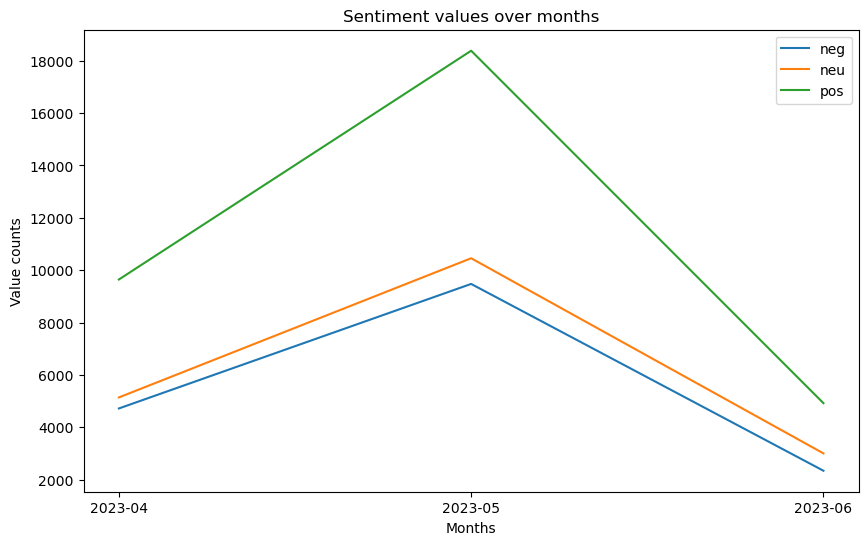

In [85]:
import matplotlib.pyplot as plt
plt.style.use('default')
%matplotlib inline

df_complete['Comment date'] = pd.to_datetime(df_complete['Comment date'])
df_grouped = df_complete.groupby([df_complete['Comment date'].dt.to_period('M'), 'Sentiment']).size().unstack()

df_grouped.index = df_grouped.index.astype(str)
plt.figure(figsize = (10, 6))
for col in df_grouped.columns:
    plt.plot(df_grouped.index, df_grouped[col], label = col)

plt.legend()

plt.xlabel('Months')
plt.ylabel('Value counts')

plt.title('Sentiment values over months')
plt.legend()
plt.savefig('reddit_sentiment_time_analysis.png')
plt.show()

# TextBlob

In [86]:
import pandas as pd

df = pd.read_csv("chatgpt_reddit - Complete.csv")

## Preprocessing

### Detecting deleted comments (by moderators)

In [87]:
number_of_del_comments = len(df[df['Comment'] == '[deleted]'])
print(number_of_del_comments)

930


### Detecting deleted comments (by users)

In [88]:
number_of_del_comments = len(df[df['Comment'] == '[removed]'])
print(number_of_del_comments)

224


In [89]:
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import re

def clean_data(review):
    
    no_punc = re.sub(r'[^\w\s]', '', review)
    no_digits = ''.join([i for i in no_punc if not i.isdigit()])
    
    return(no_digits)

df['Post title'] = df['Post title'].apply(clean_data)
df['Comment'] = df['Comment'].apply(clean_data)

In [90]:
stop_words = set(stopwords.words('english'))  # Import english stop words
df['Comment'] = df['Comment'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word.lower() not in stop_words]))  # Remove stop words

## Sentiment analysis

In [91]:
from textblob import TextBlob

df['Sentiment'] = ''

for index, row in df.iterrows():
    comment = row['Comment']
    
    blob = TextBlob(comment)
    sentiment = blob.sentiment.polarity
    
    if sentiment > 0:
        sentiment_label = 'pos'
    elif sentiment < 0:
        sentiment_label = 'neg'
    else:
        sentiment_label = 'neu'
    
    df.at[index, 'Sentiment'] = sentiment_label

df['Sentiment'].value_counts()

pos    31663
neu    22796
neg    13606
Name: Sentiment, dtype: int64

## Sentiment distribution

In [92]:
sizes = df["Sentiment"].value_counts()
sizes[1] += number_of_del_comments
sizes[2] += number_of_rem_comments
labels = df["Sentiment"].unique()

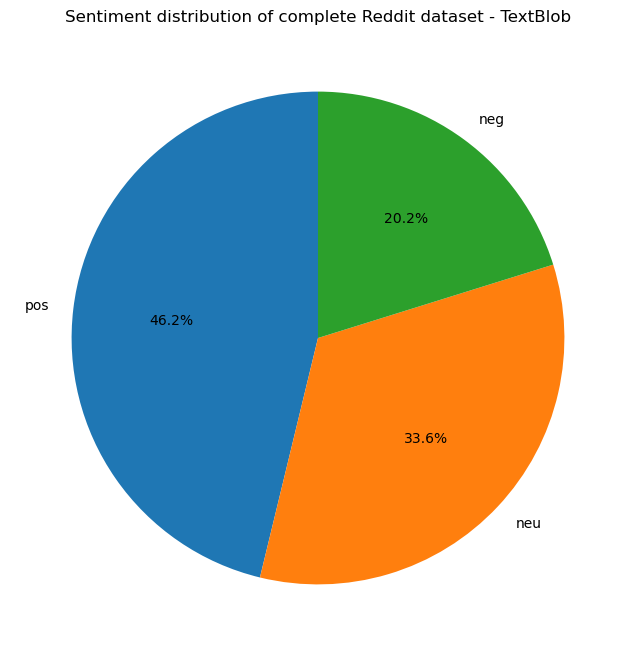

In [93]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [12, 8]

plt.pie(sizes, labels = labels, autopct = '%1.1f%%', shadow = False, startangle = 90)
plt.title("Sentiment distribution of complete Reddit dataset - TextBlob")
plt.savefig("pie_textblobsentiment-complete.png")
plt.show()